In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy.signal import argrelextrema
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [22]:
glovedf = pd.read_csv('./phaseone-gloves.csv')

In [23]:
glovedf.head()

,Category Name,Unit,Price
0,Leather Safety Gloves,Pair,10
1,Leather Safety Gloves,Pair,12
2,Leather Safety Gloves,Pair,12
3,Leather Safety Gloves,Pair,20
4,Leather Safety Gloves,Pair,23


In [24]:
glove_units=glovedf['Unit'].unique()
print(glove_units,'gloves')

['Pair' 'Piece' 'pack' 'Unit' 'Pack' 'Unit/Onwards' 'Pair(s)' 'unit' 'Set'
 'Pieces'] gloves


In [25]:
glovedf.describe()

,Price
count,144.000000
mean,432.006944
std,1794.526723
min,10.000000
25%,50.750000
50%,92.500000
75%,180.000000
max,18974.000000


In [26]:
glovedf['Unit'].value_counts()

Pair            113
unit              9
Piece             6
pack              5
Pack              3
Unit              3
Pair(s)           2
Set               1
Unit/Onwards      1
Pieces            1
Name: Unit, dtype: int64

In [27]:
for each in glove_units:
    print(each,glovedf[glovedf['Unit']==each]['Price'].mean())

Pair 102.5575221238938
Piece 136.66666666666666
pack 4507.0
Unit 318.6666666666667
Pack 766.3333333333334
Unit/Onwards 100.0
Pair(s) 315.0
unit 2442.777777777778
Set 600.0
Pieces 695.0


Some of the above units like 'Pack', 'Set', 'pack' are unsignificant as we do not know how many are inside that. 'Unit/Onwards' is also unsignificant as that is like a starting range for the product. We assume remaining all units 'Pair', 'Piece', 'pack', 'Unit','Pair(s)' 'unit', 'Pieces' are trying to represent the same, which is 'Pair': A pair of leather gloves.

In [28]:
glovedf=glovedf.drop(glovedf[(glovedf['Unit']=='Pack')].index)
glovedf=glovedf.drop(glovedf[(glovedf['Unit']=='pack')].index)
glovedf=glovedf.drop(glovedf[(glovedf['Unit']=='Set')].index)


In [29]:
glovedf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 142
Data columns (total 3 columns):
Category Name    135 non-null object
Unit             135 non-null object
Price            135 non-null int64
dtypes: int64(1), object(2)
memory usage: 4.2+ KB


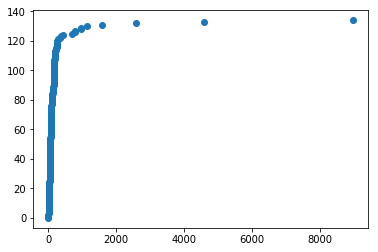

In [30]:
array=np.arange(135)
plt.scatter(glovedf['Price'],array);

(0, 2000)

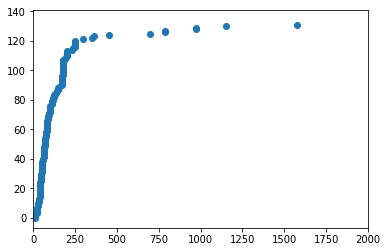

In [31]:
plt.scatter(glovedf['Price'],array);
plt.xlim([0,2000])

In [32]:
glove_z = np.abs(stats.zscore(glovedf['Price']))

After obtaing z-score we are not considering all entries whse z-score is greater than 3 or less than -3 and also we are considering only some units values as unit conversion is not as indicative as the sugar example given.

In [33]:
glovedf[(glove_z < 3)].describe()

,Price
count,133.000000
mean,174.511278
std,306.394962
min,10.000000
25%,50.000000
50%,85.000000
75%,180.000000
max,2594.000000


In [34]:
glovedf[(glove_z > 3)]

,Category Name,Unit,Price
141,Leather Safety Gloves,unit,4587
142,Leather Safety Gloves,unit,8978


So, these are the outliers removed by evaluation of z-score. We can clearly see from the scatter plot that these are completely far from everything else.

In [35]:
from scipy.stats import gaussian_kde
def kde_scipy(x, x_grid, bandwidth, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

In [36]:
npa=glovedf[(glove_z < 3)]['Price']

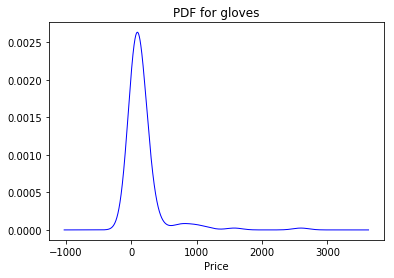

In [37]:
y_grid=np.linspace(np.amin(npa)-(np.amax(npa)-np.amin(npa))*0.4,np.amax(npa)+(np.amax(npa)-np.amin(npa))*0.4,10000)
ideal=1.06*(np.std(npa))*((len(npa)**(-1/5)))
pdf = kde_scipy(npa, y_grid, bandwidth=ideal)
plt.plot(y_grid, pdf, color='blue', alpha=1, lw=1)
plt.title('PDF for gloves')
plt.xlabel('Price')
plt.show()

In [38]:
w=((np.amax(npa)-np.amin(npa))*1.8)/10000

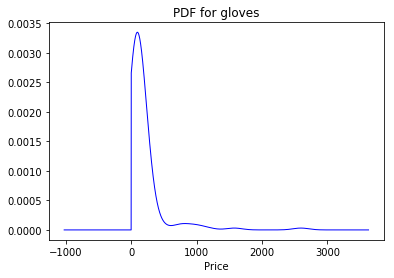

In [39]:
for a in range(len(pdf)):
    if y_grid[a] > 0:
        break
probab=np.sum(pdf[a:])*w
pdfc=pdf.copy()
for a in range(len(pdf)):
    if y_grid[a] > 0:
        break
    pdfc[a]=0
pdf1=pdfc/probab
plt.plot(y_grid, pdf1, color='blue', alpha=1, lw=1)
plt.title('PDF for gloves')
plt.xlabel('Price')
plt.show()

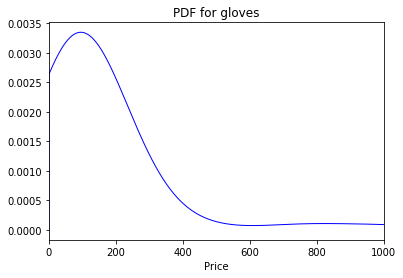

In [40]:
plt.plot(y_grid, pdf1, color='blue', alpha=1, lw=1)
plt.title('PDF for gloves')
plt.xlabel('Price')
plt.xlim([0,1000])
plt.show()

We can clearly see that the price ranges from 0 to 400 in a rough way from the distribution.

In [41]:
maxpos =np.where(pdf1==max(pdf1))[0][0];maxpos

2405

In [42]:
sum(pdf1)*w

0.9999999999999921

In [43]:
pos=int(np.where((pdf1<0.00101)&(pdf1>0.00099))[0].mean());pos

2901

In [44]:
minpos=max(np.where(pdf1==0)[0]);minpos

2200

In [45]:
ratio=(pos-maxpos)/(maxpos-minpos);ratio

2.419512195121951

In [46]:
sum(pdf1[2200:2346])

0.4364255677825189

For each step we take left of the main peak, we can approximately take 3 steps right side, to achieve the distribution-like range.

In [53]:
f_peak1=maxpos
for q in range(f_peak1):
    if np.sum(pdf1[f_peak1-q:f_peak1+3*q])*w > 0.9:
        print(np.sum(pdf1[f_peak1-q:f_peak1+3*q])*w,q)
        break
print('The range obtained for gloves is from',max(min(npa),int(np.round((f_peak1-q)*w+np.amin(npa)-(np.amax(npa)-np.amin(npa))*0.4))),'to',int(np.round((f_peak1+3*q)*w+np.amin(npa)-(np.amax(npa)-np.amin(npa))*0.4)))

0.9004394796662437 240
The range obtained for gloves is from 10 to 430


In [58]:
qq2=len(pdf1)
for q in range(len(pdf1)):
    for p in range(len(pdf1)-(q+1)):
        if np.sum(pdf1[p:p+q+1])*w > 0.6:
            print(np.sum(pdf1[p:p+q+1])*w,p,q)
            break
    if np.sum(pdf1[p:p+q+1])*w > 0.6:
        break
#print('This is the range obtained for gloves ',np.round((p)*w1+np.amin(npa1)-(np.amax(npa1)-np.amin(npa1))*0.4),np.round((p+q+1)*w1+np.amin(npa1)-(np.amax(npa1)-np.amin(npa1))*0.4))  
print('The range obtained for gloves is from',max(min(npa),int(np.round((p)*w+np.amin(npa)-(np.amax(npa)-np.amin(npa))*0.4))),'to',int(np.round((p+q+1)*w+np.amin(npa)-(np.amax(npa)-np.amin(npa))*0.4)))

0.6002102113243765 2201 415
The range obtained for gloves is from 10 to 194
